In [1]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearson3

In [2]:
def retrieve_retro_data(
    feature_id: int,
    odir: Path = Path("NWM_data"),
    url: str = "s3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/chrtout.zarr"
) -> pd.Series:
    """This function retrieves NWM retrospective data from AWS
    and returns a pandas.Series of streamflow data for a single
    channel feature.
    """
    # Check local file
    ofile = odir / f"NWM_{feature_id}.nc"
    if ofile.exists():
        return xr.open_dataarray(ofile).to_dataframe()["streamflow"]

    # Get xarray.dataset
    # Requires s3fs and zarr be installed
    ds = xr.open_dataset(
        url,
        backend_kwargs={
            "storage_options": {"anon": True},
            "consolidated": True
        },
        engine="zarr"
    )

    # Extract time series data
    da = ds.streamflow.sel(feature_id=feature_id)

    # Save
    odir.mkdir(exist_ok=True, parents=True)
    da.to_netcdf(ofile)

    # Return Series
    return da.to_dataframe()["streamflow"]

In [3]:
# Load data as pandas.Series
streamflow = retrieve_retro_data(101)

In [4]:
# Result is pandas.Series of streamflow data with a DateTimeIndex in m^3/s
streamflow.head()

time
1979-02-01 01:00:00    2.47
1979-02-01 02:00:00    2.47
1979-02-01 03:00:00    2.47
1979-02-01 04:00:00    2.46
1979-02-01 05:00:00    2.46
Name: streamflow, dtype: float64

In [5]:
# Look at data limits
streamflow.index.min(), streamflow.index.max()

(Timestamp('1979-02-01 01:00:00'), Timestamp('2023-02-01 00:00:00'))

In [6]:
# Trim to whole water-years (Oct 1 - Sep 30)
# Note padding of 6 days so every water year
# will have the same number of 7-day averages
start = pd.Timestamp("1979-10-01T00:00") - pd.Timedelta("6d")
end = pd.Timestamp("2022-09-30T23:00")
streamflow_trimmed = streamflow[start:end]

In [7]:
# NWM data is hourly. The 7Q10 method assumes daily streamflow
# We'll need to resample to daily mean streamflow, first
streamflow_daily = streamflow_trimmed.resample("1D", closed="left", label="left").mean()

In [8]:
# Resample to 7-day rolling average streamflow
# Note that with NWM data, you shouldn't have to worry about
# handling missing data. If this were observed, we'd need to handle that.
streamflow_7day = streamflow_daily.rolling(window="7d", min_periods=7).mean().dropna()

In [9]:
# Note that after all this resampling
# we've lost the first six days of data
# That is the first time we can take a 7-day average
# is the end of the 7th day of the entire record.
streamflow_7day.head()

time
1979-10-01    0.553869
1979-10-02    0.596369
1979-10-03    0.628095
1979-10-04    0.650417
1979-10-05    0.664643
Freq: D, Name: streamflow, dtype: float64

In [10]:
# Now we compute the yearly minimums
streamflow_yearly_min = streamflow_7day.resample("1YE").min()

# Update the index
streamflow_yearly_min.index.name = "water_year"
streamflow_yearly_min.index = streamflow_yearly_min.index.year

In [11]:
streamflow_yearly_min.head()

water_year
1979    0.327738
1980    0.070000
1981    0.052619
1982    0.080000
1983    0.052798
Name: streamflow, dtype: float64

In [12]:
# Empirical 7Q10
empirical_7Q10 = streamflow_yearly_min.quantile(0.1)
f"Empirical 7Q10 rounded to model precision is {empirical_7Q10:.2f} m^3/s"

'Empirical 7Q10 rounded to model precision is 0.03 m^3/s'

In [13]:
# Fitting to a distribution
pearson_params = pearson3.fit(streamflow_yearly_min)
fitted_7Q10 = pearson3.ppf(0.1, *pearson_params)
f"Fitted 7Q10 rounded to model precision is {fitted_7Q10:.2f} m^3/s"

'Fitted 7Q10 rounded to model precision is 0.02 m^3/s'

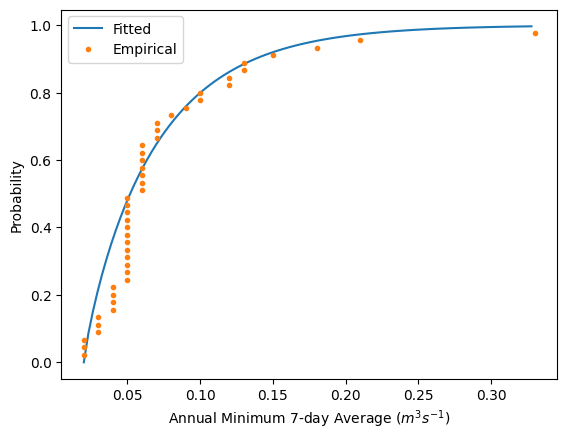

In [14]:
# Plot fit
x = np.linspace(streamflow_yearly_min.min(), streamflow_yearly_min.max(), 100)
y = pearson3.cdf(x, *pearson_params)
n = len(streamflow_yearly_min)
x_emp = np.round(streamflow_yearly_min.sort_values(), 2)
y_emp = (np.arange(n) + 1.0) / (n + 1.0)
plt.plot(x, y, label="Fitted")
plt.plot(x_emp, y_emp, ".", label="Empirical")
plt.xlabel("Annual Minimum 7-day Average ($m^3 s^{-1}$)")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [15]:
# Notice in the plot above that the fitted distribution is a lot smoother
# This is because the model output has fixed precision (0.01 m^3/s)
# When dealing with low flow thresholds that are going to be applied to 
# modeled streamflow, the increased precision of the fitted distribution
# isn't really doing anything. So in this case it may be better to just go with 
# the empirical values.